In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [57]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [61]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [66]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [62]:
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [11]:
# Find most recent date
engine.execute("SELECT * FROM Measurement ORDER BY date DESC LIMIT 1").fetchall()

[(2724, 'USC00519397', '2017-08-23', 0.0, 81.0)]

In [12]:
# Use date from 12 months ago to get precipitation from last year
prcp_data = (session.query(Measurement.date, Measurement.prcp)
                  .filter(Measurement.date > dt.date(2016,8,22)) # Had the date set to the 23rd day but it started from the
                  .order_by(Measurement.date)                    # 24th, so I switched the date to the 22nd day
                  .all())
#print(prcp_data)

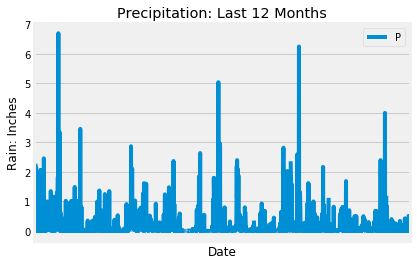

In [107]:
# Convert to df and prepare bar graph
prcp_df = pd.DataFrame(prcp_data)
#prcp_df.head(20)

prcp_chart = prcp_df.set_index('date')
prcp_chart = prcp_chart.sort_index(ascending=True)

# Create plot
prcp_chart.plot(title="Precipitation: Last 12 Months")
plt.xlabel('Date')
plt.ylabel('Rain: Inches')
plt.legend('Precipitation')
plt.xticks([])
plt.show()

# The x axis values were too large and overlapped each other so I removed them. Stackoverlfow had a bit about setting
# the x ticks to an empty list, that way the label remains.

In [32]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_chart.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [33]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station).count()
print(station_count)

9


In [34]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_frequency = (session.query(Measurement.station, func.count(Measurement.station))
                        .group_by(Measurement.station)
                        .order_by(func.count(Measurement.station).desc())
                        .all())
print(station_frequency)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [35]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

#find name of most active station (highest count from above series)
most_active = Measurement.id = 'USC00519281'
station_name = (session.query(Station.name)
                      .filter_by(station = most_active))
station_name = station_name[0][0]
# print(station_name)

# find highest temp at that station
high_temp = (session.query(Measurement.tobs)
                    .filter(Measurement.station == most_active)
                    .order_by(Measurement.tobs.desc())
                    .first())
high_temp = high_temp[0]
# print(high_temp)

low_temp = (session.query(Measurement.tobs)
                    .filter(Measurement.station == most_active)
                    .order_by(Measurement.tobs.asc())
                    .first())
low_temp = low_temp[0]
# print(low_temp)

avg_temp = (session.query(func.avg(Measurement.tobs))
                   .filter(Measurement.station == most_active))
avg_temp = avg_temp[0][0]
# print(avg_temp)

print(station_name, low_temp, high_temp, avg_temp)

WAIHEE 837.5, HI US 54.0 85.0 71.66378066378067


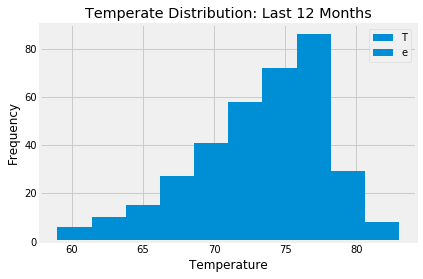

In [36]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active = Measurement.id == 'USC00519281'
temp_data = (session.query(Measurement.date, Measurement.tobs)
                  .filter(Measurement.date > dt.date(2016,8,22))
                  .filter(Measurement.station == most_active)
                  .order_by(Measurement.date)
                  .all())

# Convert to df and prepare bar graph
temp_df = pd.DataFrame(temp_data)
#prcp_df.head(20)

temp_chart = temp_df.set_index('date')
temp_chart = temp_chart.sort_index(ascending=True)

# Create plot
temp_chart.plot(title="Temperate Distribution: Last 12 Months", kind='hist')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend('Temps')
plt.show()

In [37]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [40]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2017-02-28', '2017-03-11'))

[(62.0, 70.94594594594595, 82.0)]


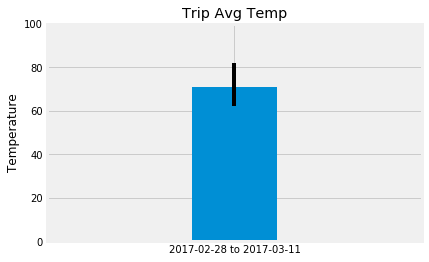

In [50]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_dates = '2017-02-28 to 2017-03-11'
trip_temps = calc_temps('2017-02-28', '2017-03-11')

# Define the lower, upper, and average values
low_range = trip_temps[0][0]
avg_range = trip_temps[0][1]
upper_range = trip_temps[0][2]

# Get error bar values
min_error = avg_range - low_range
max_error = upper_range - avg_range

# Create error bars
error_bars = np.array([[min_error], [max_error]])

# Plot chart
plt.bar(trip_dates, avg_range, yerr=error_bars)
plt.ylim(0, 100)
plt.xlim(-1.75, 1.75)
plt.title('Trip Avg Temp')
plt.ylabel('Temperature')
plt.show()

In [155]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

# start_date = (session.query(Measurement.date)
#                       .filter(Measurement.date == '2017-02-28')
#                       .all())
# end_date = (session.query(Measurement.date)
#                       .filter(Measurement.date == '2017-03-11')
#                       .all())

# start_date = Measurement.date = dt.date(2017,2,28)
# end_date = Measurement.date = dt.date(2017,3,11)

start_date = '2017-02-28'
end_date = '2017-03-11'

criteria = ([Station.station,
            Station.name,
            func.sum(Measurement.prcp),
            Station.latitude,
            Station.longitude,
            Station.elevation])

station_info = (session.query(*criteria)
                       .filter(Station.station == Measurement.station)
                       .filter(Measurement.date >= start_date)
                       .filter(Measurement.date <= end_date)
                       .group_by(Station.id)
                       .order_by(func.sum(Measurement.prcp).desc())
                       .all())

# station_df = pd.DataFrame(station_info)
# station_df.head(5)

station_table = pd.DataFrame(np.array(station_info))
station_table = station_table.rename(columns={0:'Station ID',1:'Station Name',2:'Total Rainfall (Inches)',
                                     3:'Latitude',4:'Longitude',5:'Elevation'})

station_table


# I was getting stuck here, hence all the commented out stuff.
# Long story short, I was trying to join the tables by ID instead of station,
# but ID was not actually a column in the data sets. The only other one in common was the station column.
# Then I just renamed the columns to make some sense.

,Station ID,Station Name,Total Rainfall (Inches),Latitude,Longitude,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",1068.0899999999997,21.3331,-157.8025,152.4
1,USC00519281,"WAIHEE 837.5, HI US",588.6400000000001,21.45167,-157.84888999999998,32.9
2,USC00513117,"KANEOHE 838.1, HI US",382.6199999999998,21.4234,-157.8015,14.6
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",295.6800000000001,21.33556,-157.71139,19.5
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",234.49000000000007,21.5213,-157.8374,7.0
5,USC00519397,"WAIKIKI 717.2, HI US",131.61999999999992,21.2716,-157.8168,3.0
6,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",92.67999999999995,21.3152,-157.9992,0.9
7,USC00518838,"UPPER WAHIAWA 874.3, HI US",70.86999999999999,21.4992,-158.0111,306.6
8,USC00517948,"PEARL CITY, HI US",43.43999999999998,21.3934,-157.9751,11.9


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


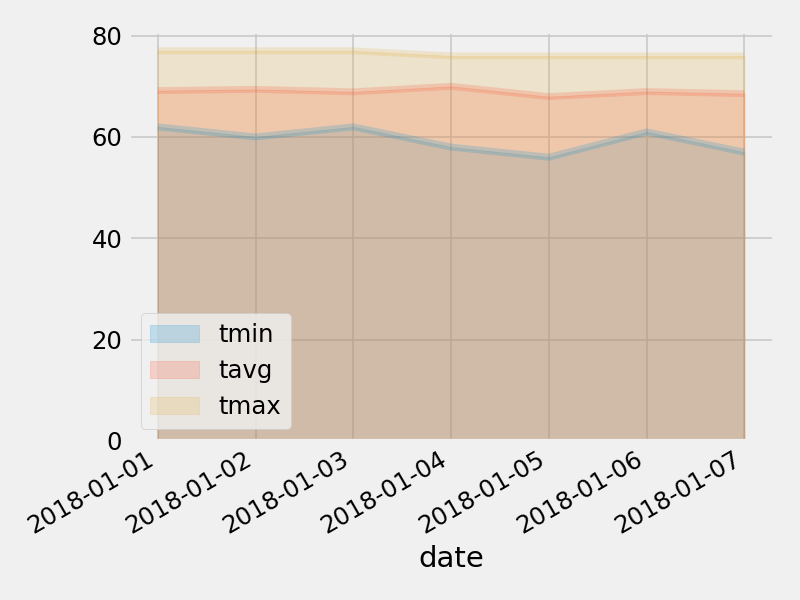

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
